In [3]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [4]:
UTILS = '/Users/krishnakalyan3/Educational/PumpIt/utils/'
import sys
sys.path.append(UTILS)
from utils import write_data, read_data

ImportError: cannot import name 'write_data'

In [6]:
import numpy
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import LabelEncoder

In [7]:
TRAIN_PATH = '/Users/krishnakalyan3/Educational/PumpIt/data/train/' + 'train.pkl'
VAL_PATH = '/Users/krishnakalyan3/Educational/PumpIt/data/valid/' + 'valid.pkl'

In [8]:
x_train, y_train = read_data(TRAIN_PATH)

NameError: name 'read_data' is not defined

In [35]:
y_train['status_group'].value_counts()

functional                 25815
non functional             18255
functional needs repair     3450
Name: status_group, dtype: int64

functional needs repair seems to have fewer values compared to other cateogries. We will sample our data in a better way. We wil need to explore the further later

### Label Encoding Target

In [31]:
lbl = LabelEncoder()
lbl.fit(y_train['status_group'])
y = lbl.transform(y_train['status_group'])

### Important Features According to RF

In [38]:
# Top 7 featuers
important_columns = ['quantity', 'quality_group', 'longitude', 'latitude', 'subvillage', 'source_class']

In [40]:
x_train[important_columns].head()

,quantity,quality_group,longitude,latitude,subvillage,source_class
55424,enough,good,38.267292,-4.783454,Irente Juu,groundwater
28170,insufficient,salty,36.561550,-5.309293,Kanisani,groundwater
20007,insufficient,good,35.269396,-3.217454,Madukani,groundwater
7842,enough,good,37.624801,-3.141919,Kihemba,groundwater
22217,enough,good,29.904637,-4.534989,Kibuye,surface


#### Pre Processing Steps
- K-Means on Lat Long
- Convert Entitiy Encode Cat Variables
- Validation Accuracy / F1 score
- Simple Submisison

In [1]:
from sklearn.cluster import KMeans
import numpy as np
from scipy.spatial.distance import cdist

In [2]:
lat_long = ['latitude', 'longitude']
X = x_train[lat_long]

NameError: name 'x_train' is not defined

In [70]:
k = 5
kmeanModel = KMeans(n_clusters=k).fit(X)
dist_error = sum(np.min(cdist(X, kmeanModel.cluster_centers_, 'euclidean'), axis=1)) / X.shape[0]

In [71]:
k_out = kmeanModel.fit_predict(X)

In [72]:
from scipy.stats import itemfreq
itemfreq(k_out)

array([[    0, 13681],
       [    1,  1445],
       [    2,  8058],
       [    3, 10899],
       [    4, 13437]])

#### Optimal Cluster using elbow method

In [55]:
distortions = []
for k in range(2, 12):
    print('Cluster {}'.format(k))
    kmeanModel = KMeans(n_clusters=k).fit(X)
    dist_error = sum(np.min(cdist(X, kmeanModel.cluster_centers_, 'euclidean'), axis=1)) / X.shape[0]
    distortions.append([k, dist_error])

Cluster 2
Cluster 3
Cluster 4
Cluster 5
Cluster 6
Cluster 7
Cluster 8
Cluster 9
Cluster 10
Cluster 11


In [58]:
dist_data = np.array(distortions)
dist_data

array([[  2.        ,   3.50127696],
       [  3.        ,   2.46187827],
       [  4.        ,   1.85601856],
       [  5.        ,   1.54900131],
       [  6.        ,   1.35449769],
       [  7.        ,   1.18894653],
       [  8.        ,   1.11176515],
       [  9.        ,   1.01384607],
       [ 10.        ,   0.95892545],
       [ 11.        ,   0.8772258 ]])

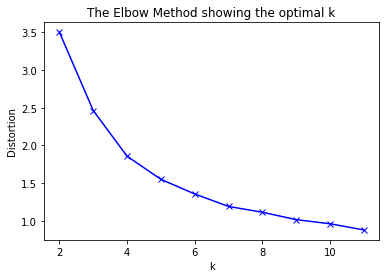

In [69]:
plt.plot(dist_data[:,0], dist_data[:,1], 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()

#### 5 cluster centers look good

### Embedding Categroical Variables

In [74]:
cat_columns = ['quantity', 'quality_group', 'subvillage', 'source_class']

In [83]:
for i in cat_columns:
    val_count = x_train[i].value_counts()
    print('### Cat {}, Modalities {}, NAs {} ###'.format(i, len(val_count), ))
    print(val_count)

### Cat quantity, Modalities 5 ###
enough          26438
insufficient    12201
dry              5022
seasonal         3227
unknown           632
Name: quantity, dtype: int64
### Cat quality_group, Modalities 6 ###
good        40628
salty        4181
unknown      1501
milky         639
colored       393
fluoride      178
Name: quality_group, dtype: int64
### Cat subvillage, Modalities 17250 ###
Madukani                 407
Majengo                  407
Shuleni                  401
Kati                     298
Mtakuja                  204
Sokoni                   188
M                        150
Muungano                 138
Mbuyuni                  138
Mlimani                  124
Songambele               119
Miembeni                 116
Msikitini                107
1                        106
Mjini                     91
Kibaoni                   89
Kanisani                  87
Mkwajuni                  85
Mapinduzi                 84
I                         84
Mabatini               

embedding length would be number of modalities equal to 5

In [120]:
from keras.models import Sequential
from keras.layers.core import Dense, Activation, Reshape
from keras.layers import Merge
from keras.layers.embeddings import Embedding
from keras.callbacks import ModelCheckpoint
import h5py
import pandas as pd
import numpy as np
import keras as K
from keras.layers import Input, Embedding, Dense, Dropout, merge, Flatten
from keras.regularizers import l2
from keras.models import Model
import keras.backend as K
from keras.optimizers import Adam
from keras.callbacks import Callback, TensorBoard

In [126]:
# important_columns = ['quantity', 'quality_group', 'longitude', 'latitude', 'subvillage', 'source_class']
def model():
    cat1_ip = Input(shape=(1,), dtype='int64', name='clusters')
    cat2_ip = Input(shape=(1,), dtype='int64', name='quantity')
    cat3_ip = Input(shape=(1,), dtype='int64', name='quality_group')
    cat4_ip = Input(shape=(1,), dtype='int64', name='subvillage')
    cat5_ip = Input(shape=(1,), dtype='int64', name='source_class')
    
    c1 = Embedding(cat1_ip, 5, input_length=1)(cat1_ip)
    c2 = Embedding(cat2_ip, 5, input_length=1)(cat2_ip)
    c3 = Embedding(cat3_ip, 5, input_length=1)(cat3_ip)
    c4 = Embedding(cat4_ip, 10, input_length=1)(cat4_ip)
    c5 = Embedding(cat5_ip, 5, input_length=1)(cat5_ip)
    
    
    x = concatenate([c1, c2, c3, c5, c5])
    x = Flatten()(x)

    x = Dropout(0.5)(x)
    x = Dense(1000, activation='relu')(x)
    x = Dropout(0.5)(x)
    x = Dense(1)(x)
    
    model = Model([u_ip, m_ip], x)
    model.compile(Adam(5e-4), loss='rmsprop', metrics=[rmse])
    return model

In [127]:
x_train['subvillage'].value_counts()[1:10]

Madukani    407
Shuleni     401
NaN         299
Kati        298
Mtakuja     204
Sokoni      188
M           150
Mbuyuni     138
Muungano    138
Name: subvillage, dtype: int64

In [128]:
# Since its a subvillage it looks like some villages were not entered by the operator. Approaches I would like to try replace the 
# missing values with its median or mark them as unknown. 

In [129]:
x_train['subvillage'] = x_train['subvillage'].fillna('NaN')

In [130]:
model = model()

ValueError: Shapes must be equal rank, but are 2 and 0
	From merging shape 0 with other shapes. for 'embedding_3/random_uniform/shape' (op: 'Pack') with input shapes: [?,1], [].